In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from itertools import chain
from collections import Counter
from wordcloud import WordCloud

from src.data.some_dataloader import *

In this notebook we will: 
- find how often each article is used in the Wikispeedia game (i.e. how many times each article was clicked on)
- find articles that are most/least used 
- link each article to its category 
- find most used categories

# Import data 

In [3]:
articles = load_articles_dataframe()
categories = load_categories_dataframe()
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()

In [4]:
articles

,name
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts
...,...
4599,Zionism
4600,Zirconium
4601,Zoroaster
4602,Zuid-Gelders


In [5]:
categories

,articles,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists
...,...,...
5199,Zirconium,subject.Science.Chemistry.Chemical_elements
5200,Zoroaster,subject.People.Religious_figures_and_leaders
5201,Zuid-Gelders,subject.Geography.European_Geography
5202,Zuid-Gelders,subject.Language_and_literature.Languages


In [6]:
finished_paths

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,Yagan;Ancient_Egypt;Civilization,NaN
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0
51315,12863abb7887f890,1385095372,228,Yagan;Australia;England;France;United_States;T...,NaN
51316,19f8284371753362,1298792567,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0


In [7]:
unfinished_paths

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart
24871,232f992e57d43e8d,1389787697,6,Modern_history,Hollandic,restart
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout


# Usage of articles

In [8]:
paths = pd.concat([finished_paths["path"], unfinished_paths["path"]])

paths_merged = paths.apply(lambda row: row.split(';'))

clicks_list = paths_merged.values.flatten().tolist()
clicks_list = list(chain.from_iterable(clicks_list))

print(f'there are {len(clicks_list)} clicks in the whole whikispeedia dataset (both finished and unfinished paths)')

there are 476073 clicks in the whole whikispeedia dataset (both finished and unfinished paths)


In [9]:
article_list = list(articles['name'])

# count number of occurences of each article
counts = Counter(clicks_list)
occurences = {item: counts[item] for item in article_list}

df_articles_count = pd.DataFrame(list(occurences.items()), columns = ['article', 'count']) # df containing the click counts for each article
df_articles_count

,article,count
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0
1,%C3%85land,4
2,%C3%89douard_Manet,7
3,%C3%89ire,13
4,%C3%93engus_I_of_the_Picts,0
...,...,...
4599,Zionism,27
4600,Zirconium,34
4601,Zoroaster,20
4602,Zuid-Gelders,10


In [10]:
df_articles_count_sorted = df_articles_count.sort_values(by='count', ascending=False)

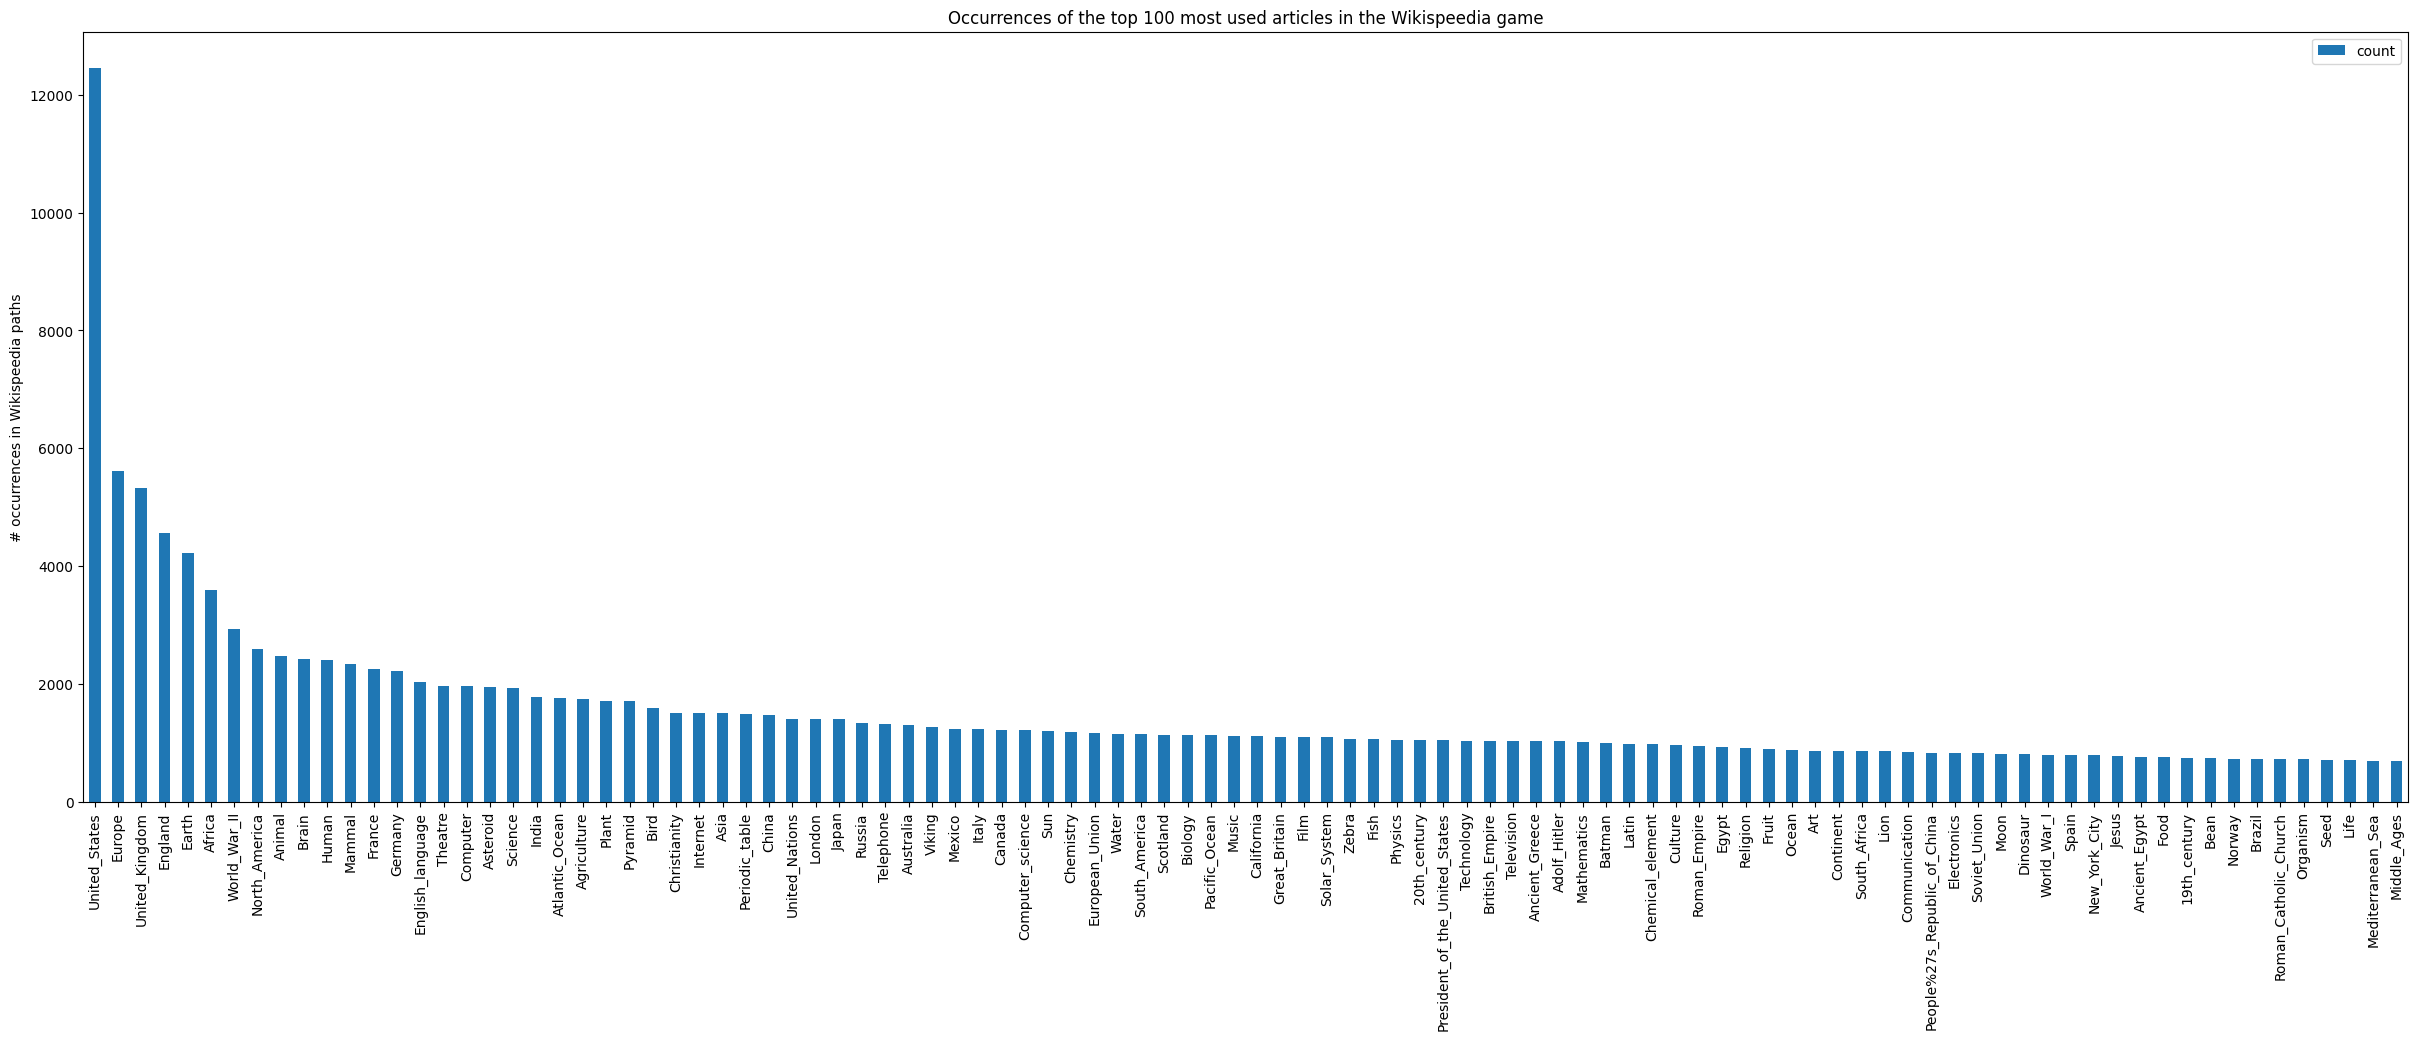

In [11]:
# plot the most used articles 
df_articles_count_sorted.head(100).plot(kind='bar', stacked=True, figsize=(30, 10))

plt.xticks(ticks=range(len(df_articles_count_sorted.head(100))), labels=df_articles_count_sorted['article'].head(100), fontsize=10)
plt.ylabel('# occurrences in Wikispeedia paths')
plt.title("Occurrences of the top 100 most used articles in the Wikispeedia game")
plt.show()

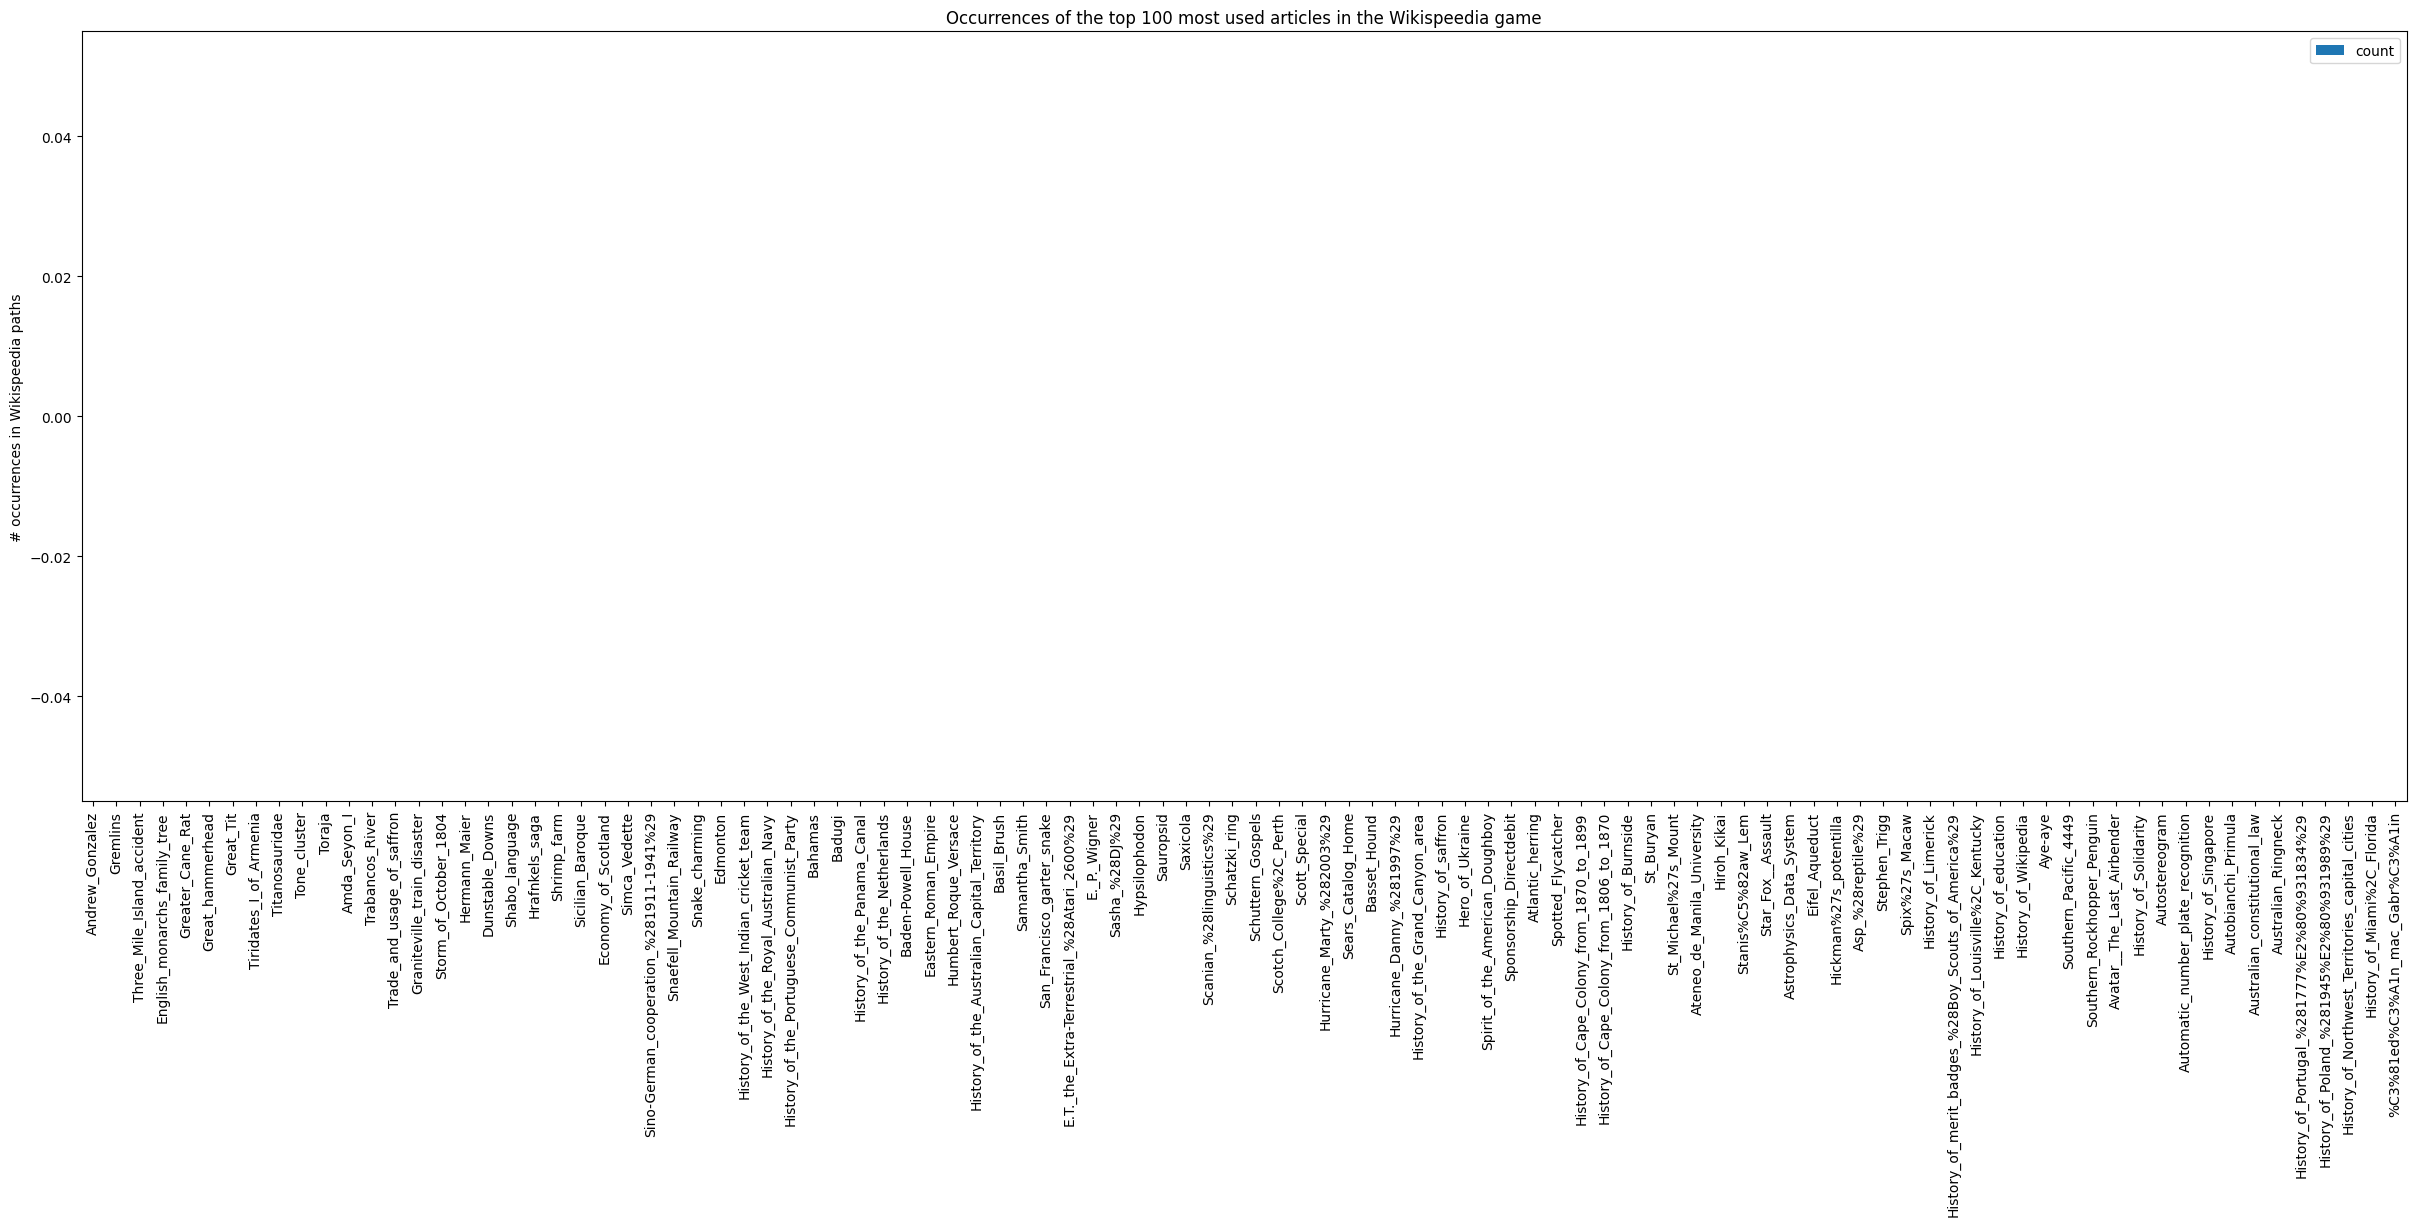

In [12]:
# plot the least used articles 
df_articles_count_sorted.tail(100).plot(kind='bar', stacked=True, figsize=(30, 10))

plt.xticks(ticks=range(len(df_articles_count_sorted.tail(100))), labels=df_articles_count_sorted['article'].tail(100), fontsize=10)
plt.ylabel('# occurrences in Wikispeedia paths')
plt.title("Occurrences of the top 100 most used articles in the Wikispeedia game")
plt.show()

# so many articles are never used (never clicked :( sniiif)

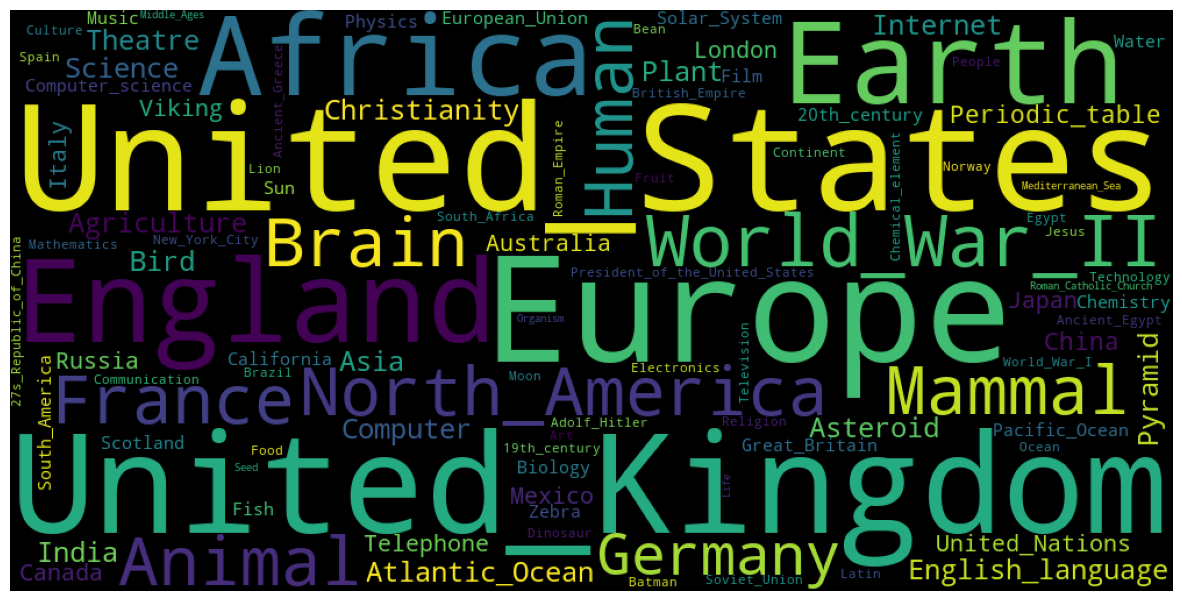

In [13]:
# alternative fun visualization of most used articles 
unique_string=(" ").join(list(df_articles_count_sorted['article'].head(100)))
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [14]:
# find articles that are never clicked on
never_used_articles = df_articles_count['article'][df_articles_count['count'] == 0]

print(f'there are {len(never_used_articles)} articles that are never clicked on in the game')

there are 422 articles that are never clicked on in the game
